# Test Prediction Server Locally

Test the prediction server directly without Label Studio to verify:
1. Backend is producing valid predictions
2. Response format is correct
3. Keypoints are in the right locations

In [1]:
import requests
import json
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 1. Test Server Health

In [2]:
# Test health endpoint
response = requests.get("http://localhost:9090/health")
print(f"Health check status: {response.status_code}")
print(json.dumps(response.json(), indent=2))

Health check status: 200
{
  "status": "UP",
  "model_class": "HomographyKeypointsPipeline"
}


## 2. Send Prediction Request

In [3]:
# Prepare a prediction request in Label Studio format
test_image = "/data/local-files/?d=images/PATEK_nab_005/PATEK_nab_005_03_face_q3.jpg"

request_payload = {
    "tasks": [
        {
            "data": {
                "image": test_image
            }
        }
    ]
}

print("Request payload:")
print(json.dumps(request_payload, indent=2))

Request payload:
{
  "tasks": [
    {
      "data": {
        "image": "/data/local-files/?d=images/PATEK_nab_005/PATEK_nab_005_03_face_q3.jpg"
      }
    }
  ]
}


In [4]:
# Send prediction request
response = requests.post(
    "http://localhost:9090/predict",
    json=request_payload,
    headers={"Content-Type": "application/json"}
)

print(f"Prediction status: {response.status_code}")
print(f"\nRaw response:")
print(response.text)

Prediction status: 200

Raw response:
{"results":[{"result":[{"id":"9dcfeb11","from_name":"keypoints","to_name":"image","type":"keypointlabels","original_width":1920,"original_height":2560,"image_rotation":0,"value":{"x":50.87,"y":21.77,"width":1.5,"keypointlabels":["Top"]},"score":null},{"id":"b698a9e3","from_name":"keypoints","to_name":"image","type":"keypointlabels","original_width":1920,"original_height":2560,"image_rotation":0,"value":{"x":51.74,"y":84.01,"width":1.5,"keypointlabels":["Bottom"]},"score":null},{"id":"9737f80c","from_name":"keypoints","to_name":"image","type":"keypointlabels","original_width":1920,"original_height":2560,"image_rotation":0,"value":{"x":14.52,"y":53.13,"width":1.5,"keypointlabels":["Left"]},"score":null},{"id":"022515b5","from_name":"keypoints","to_name":"image","type":"keypointlabels","original_width":1920,"original_height":2560,"image_rotation":0,"value":{"x":87.97,"y":53.14,"width":1.5,"keypointlabels":["Right"]},"score":null},{"id":"98fb624e","fro

In [5]:
# Parse the response
if response.status_code == 200:
    prediction_response = response.json()
    print("\nParsed response:")
    print(json.dumps(prediction_response, indent=2))
else:
    print(f"Error: {response.status_code}")
    print(response.text)


Parsed response:
{
  "results": [
    {
      "result": [
        {
          "id": "9dcfeb11",
          "from_name": "keypoints",
          "to_name": "image",
          "type": "keypointlabels",
          "original_width": 1920,
          "original_height": 2560,
          "image_rotation": 0,
          "value": {
            "x": 50.87,
            "y": 21.77,
            "width": 1.5,
            "keypointlabels": [
              "Top"
            ]
          },
          "score": null
        },
        {
          "id": "b698a9e3",
          "from_name": "keypoints",
          "to_name": "image",
          "type": "keypointlabels",
          "original_width": 1920,
          "original_height": 2560,
          "image_rotation": 0,
          "value": {
            "x": 51.74,
            "y": 84.01,
            "width": 1.5,
            "keypointlabels": [
              "Bottom"
            ]
          },
          "score": null
        },
        {
          "id": "9737f80c",
  

## 3. Extract and Visualize Keypoints

In [6]:
# Extract keypoints from response
if response.status_code == 200:
    results = prediction_response.get("results", [])
    
    if results:
        prediction = results[0]
        print(f"Model version: {prediction.get('model_version')}")
        print(f"Score: {prediction.get('score')}")
        
        print("\nKeypoints:")
        keypoints = {}
        for item in prediction.get('result', []):
            if item['type'] == 'keypointlabels':
                label = item['value']['keypointlabels'][0]
                x = item['value']['x']
                y = item['value']['y']
                keypoints[label] = (x, y)
                print(f"  {label:8s}: x={x:6.2f}%, y={y:6.2f}%")
    else:
        print("No predictions in response")

Model version: yolo-loftr-homography-v1.0
Score: 0.716

Keypoints:
  Top     : x= 50.87%, y= 21.77%
  Bottom  : x= 51.74%, y= 84.01%
  Left    : x= 14.52%, y= 53.13%
  Right   : x= 87.97%, y= 53.14%
  Center  : x= 51.31%, y= 52.84%


## 4. Visualize Predictions on Image

Loading image from: ../downloaded_images/PATEK_nab_005/PATEK_nab_005_03_face_q3.jpg
Image size: 1920×2560


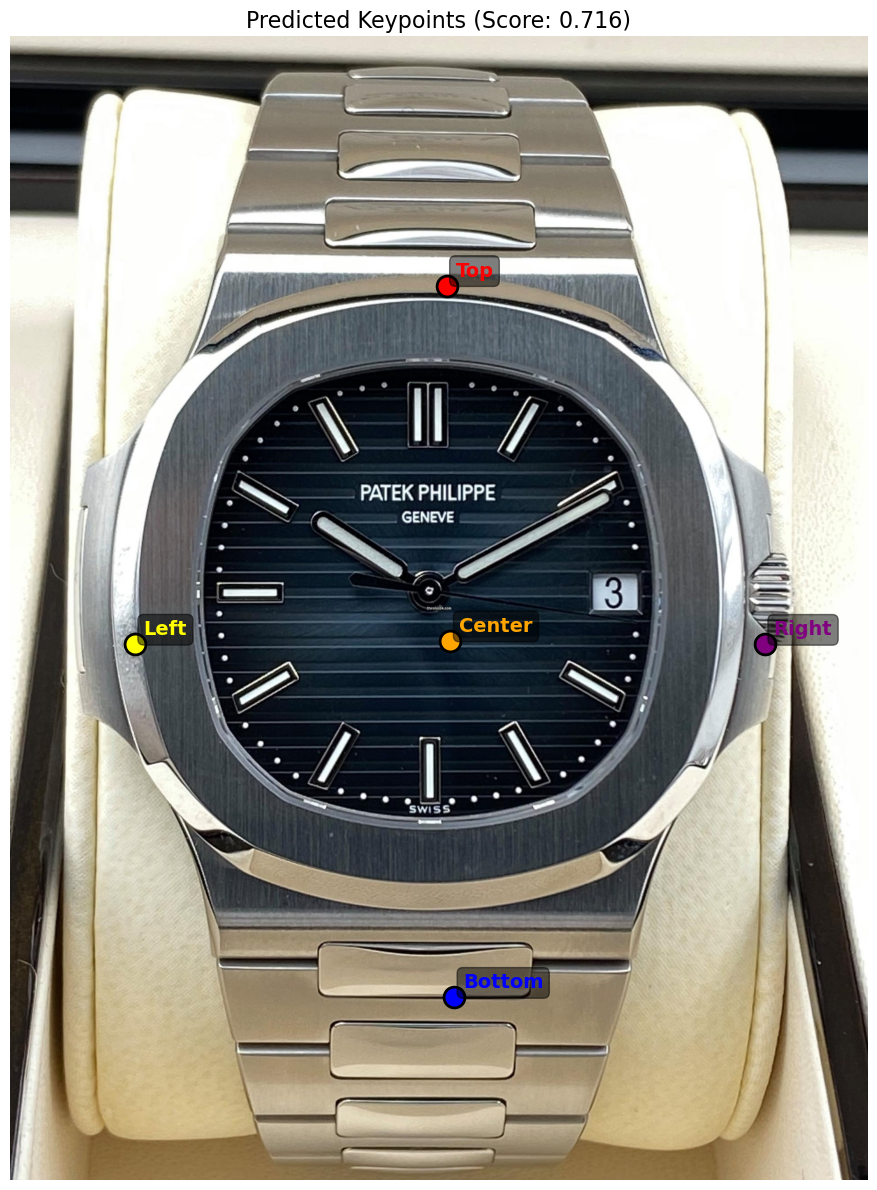

In [7]:
# Load the actual image file
# Convert Label Studio path to actual file path
image_filename = test_image.split('?d=')[-1]  # Extract 'images/PATEK_nab_005/...'
image_path = Path("../downloaded_images") / image_filename.replace('images/', '')

print(f"Loading image from: {image_path}")

if image_path.exists():
    # Load image
    img = cv2.imread(str(image_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_h, img_w = img.shape[:2]
    
    print(f"Image size: {img_w}×{img_h}")
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    ax.imshow(img_rgb)
    
    # Color mapping for keypoints
    colors = {
        'Top': 'red',
        'Bottom': 'blue',
        'Left': 'yellow',
        'Right': 'purple',
        'Center': 'orange'
    }
    
    # Plot keypoints
    for label, (x_pct, y_pct) in keypoints.items():
        # Convert from percent to pixel coordinates
        x_px = (x_pct / 100.0) * img_w
        y_px = (y_pct / 100.0) * img_h
        
        color = colors.get(label, 'white')
        ax.plot(x_px, y_px, 'o', color=color, markersize=15, 
                markeredgewidth=2, markeredgecolor='black')
        ax.text(x_px + 20, y_px - 20, label, color=color, fontsize=14, 
                fontweight='bold', bbox=dict(boxstyle='round', facecolor='black', alpha=0.5))
    
    ax.set_title(f"Predicted Keypoints (Score: {prediction.get('score', 0):.3f})", fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()
    
else:
    print(f"Image not found at: {image_path}")

## 5. Test Multiple Images

In [8]:
# Test with multiple images from different watches
test_images = [
    "/data/local-files/?d=images/PATEK_nab_001/PATEK_nab_001_01_face_q3.jpg",
    "/data/local-files/?d=images/PATEK_nab_002/PATEK_nab_002_04_tiltface_q2.jpg",
    "/data/local-files/?d=images/PATEK_nab_005/PATEK_nab_005_03_face_q3.jpg",
]

for test_img in test_images:
    print(f"\n{'='*80}")
    print(f"Testing: {test_img}")
    print('='*80)
    
    # Send prediction request
    response = requests.post(
        "http://localhost:9090/predict",
        json={"tasks": [{"data": {"image": test_img}}]},
        headers={"Content-Type": "application/json"}
    )
    
    if response.status_code == 200:
        result = response.json()
        if result.get("results"):
            pred = result["results"][0]
            print(f"Score: {pred.get('score', 0):.3f}")
            print(f"Model: {pred.get('model_version')}")
            
            # Print keypoints
            for item in pred.get('result', []):
                if item['type'] == 'keypointlabels':
                    label = item['value']['keypointlabels'][0]
                    x = item['value']['x']
                    y = item['value']['y']
                    print(f"  {label:8s}: x={x:6.2f}%, y={y:6.2f}%")
    else:
        print(f"Error: {response.status_code}")


Testing: /data/local-files/?d=images/PATEK_nab_001/PATEK_nab_001_01_face_q3.jpg
Score: 0.000
Model: yolo-loftr-homography-v1.0

Testing: /data/local-files/?d=images/PATEK_nab_002/PATEK_nab_002_04_tiltface_q2.jpg
Score: 0.884
Model: yolo-loftr-homography-v1.0
  Top     : x= 52.04%, y=  4.02%
  Bottom  : x= 52.73%, y= 50.52%
  Left    : x= 35.67%, y= 27.48%
  Right   : x= 69.11%, y= 27.07%
  Center  : x= 52.39%, y= 27.27%

Testing: /data/local-files/?d=images/PATEK_nab_005/PATEK_nab_005_03_face_q3.jpg
Score: 0.716
Model: yolo-loftr-homography-v1.0
  Top     : x= 50.87%, y= 21.77%
  Bottom  : x= 51.74%, y= 84.01%
  Left    : x= 14.52%, y= 53.13%
  Right   : x= 87.97%, y= 53.14%
  Center  : x= 51.31%, y= 52.84%


## 6. Verify Response Format for Label Studio

Check that the response matches Label Studio ML backend expected format.

In [9]:
# Verify response structure
if response.status_code == 200:
    data = response.json()
    
    print("Response structure validation:")
    print(f"✓ Has 'results' key: {'results' in data}")
    print(f"✓ 'results' is a list: {isinstance(data.get('results'), list)}")
    
    if data.get('results'):
        pred = data['results'][0]
        print(f"✓ Has 'result' key: {'result' in pred}")
        print(f"✓ Has 'score' key: {'score' in pred}")
        print(f"✓ Has 'model_version' key: {'model_version' in pred}")
        print(f"✓ 'result' is a list: {isinstance(pred.get('result'), list)}")
        
        if pred.get('result'):
            item = pred['result'][0]
            print(f"✓ Has 'type' key: {'type' in item}")
            print(f"✓ Has 'value' key: {'value' in item}")
            print(f"✓ Has 'from_name' key: {'from_name' in item}")
            print(f"✓ Has 'to_name' key: {'to_name' in item}")
            
            if 'value' in item:
                value = item['value']
                print(f"✓ Has 'x' key: {'x' in value}")
                print(f"✓ Has 'y' key: {'y' in value}")
                print(f"✓ Has 'keypointlabels' key: {'keypointlabels' in value}")
                print(f"✓ 'keypointlabels' is a list: {isinstance(value.get('keypointlabels'), list)}")
    
    print("\n✅ All checks passed!")

Response structure validation:
✓ Has 'results' key: True
✓ 'results' is a list: True
✓ Has 'result' key: True
✓ Has 'score' key: True
✓ Has 'model_version' key: True
✓ 'result' is a list: True
✓ Has 'type' key: True
✓ Has 'value' key: True
✓ Has 'from_name' key: True
✓ Has 'to_name' key: True
✓ Has 'x' key: True
✓ Has 'y' key: True
✓ Has 'keypointlabels' key: True
✓ 'keypointlabels' is a list: True

✅ All checks passed!
